In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import json
import seaborn as sns
import requests
import time
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp

In [7]:
#get jobzone df
jz = pd.read_excel('datasets/job_zone.xlsx')
jz.columns = jz.columns.str.lower().str.replace(" ","_")
jz = jz.drop(labels=['date', 'domain_source'], axis=1)   
jz = jz.rename(columns={'o*net-soc_code':'code', 'job_zone':'zone'})

In [152]:
# Set folder path
folder_name = "results/job_match_0303_1550"

# Get all JSON files
json_files = [f for f in os.listdir(folder_name) if f.endswith('.json')]

# Split files into two groups (assuming you have at least 6 files)
no_prompt_files = json_files[:3]
prompt_files = json_files[:-3]

# Initialize empty DataFrames
no_prompt_df = pd.DataFrame()
prompt_df = pd.DataFrame()

# Process no-prompt files
for file in no_prompt_files:
    try:
        file_path = os.path.join(folder_name, file)  # Safer path joining
        career = pd.read_json(file_path)
        no_prompt_df = pd.concat([no_prompt_df, career], ignore_index=True)
        no_prompt_df.to_json(folder_name+"/llama32_no_prompt.json", orient='records')
    except Exception as e:
        print(f"Error reading {file}: {str(e)}")

# Process prompt files
for file in prompt_files:
    try:
        file_path = os.path.join(folder_name, file)  # Safer path joining
        career = pd.read_json(file_path)
        prompt_df = pd.concat([prompt_df, career], ignore_index=True)
        prompt_df.to_json(folder_name+"/llama32_prompt_1.json", orient='records')
    except Exception as e:
        print(f"Error reading {file}: {str(e)}")

# # Display or return results
# print("No Prompt DataFrame shape:", no_prompt_df.shape)
# print("Prompt DataFrame shape:", prompt_df.shape)




In [52]:
no_prompt_df = pd.read_json(folder_name+"/llama3.2_no_prompt.json")
#create a column, with number 1-10, 1 repeasted 47 times, 2 repeated 47 times, etc representing iteration
no_prompt_df["iteration"] = [x // 47 for x in range(470)]
no_prompt_df

,title,ind,rating,perfect_match,related,iteration
0,"Property, Real Estate, and Community Associati...",11,3.233232e+59,0,5,0
1,General and Operations Managers,11,2.255232e+59,0,0,0
2,Emergency Management Directors,11,1.325231e+59,0,0,0
3,Appraisers of Personal and Business Property,13,3.353313e+59,0,2,0
4,Fundraisers,13,5.235345e+59,0,0,0
...,...,...,...,...,...,...
465,"Tool Grinders, Filers, and Sharpeners",51,2.314144e+59,0,0,9
466,Traffic Technicians,53,1.332235e+59,0,0,9
467,Recycling Coordinators,53,2.325333e+59,1,0,9
468,"Laborers and Freight, Stock, and Material Move...",53,3.433233e+59,0,2,9


In [9]:
# lets look at no prompt df
def get_result(df):
    score_df = df.groupby("title").agg({
        "perfect_match": "mean",
        "related": "mean",
        "ind": "first"
    }).reset_index()
    #merge with jz
    score_df = score_df.merge(right=jz, left_on="title", right_on="title")
    return score_df

In [16]:
# grouby title and get a list of perfect_match, related and first of ind and zone
def get_stats(df):
    score_df = df.groupby("title").agg({
        "perfect_match": lambda x: list(x),
        "related": lambda x: list(x),
        "ind": "first"
    }).reset_index()
    return score_df

In [27]:
pilot_data = get_stats(no_prompt_df)

In [53]:
def mean_perfect_array(df):
    #get the mean difference in df, by iteration, into a np array
    return df.groupby("iteration")["perfect_match"].mean().to_numpy()

In [54]:
the_list = []
df = mean_perfect_array(no_prompt_df)
the_list.append(df)

the_list


[array([0.21276596, 0.17021277, 0.23404255, 0.19148936, 0.23404255,
        0.23404255, 0.27659574, 0.31914894, 0.23404255, 0.17021277])]

In [11]:
plot_data = get_result(no_prompt_df)
plot_data

,title,perfect_match,related,ind,code,zone
0,Animal Breeders,0.0,0.0,45,45-2021.00,2
1,Animal Trainers,0.0,0.4,39,39-2011.00,2
2,Appraisers of Personal and Business Property,0.0,1.4,13,13-2022.00,4
3,Archivists,0.7,1.7,25,25-4011.00,5
4,Biofuels Processing Technicians,0.1,0.2,51,51-8099.01,2
5,Boilermakers,0.0,0.0,47,47-2011.00,3
6,Cartographers and Photogrammetrists,0.0,0.0,17,17-1021.00,4
7,Clinical Data Managers,0.4,1.9,15,15-2051.02,4
8,"Control and Valve Installers and Repairers, Ex...",0.0,0.3,49,49-9012.00,3
9,"Cooks, Institution and Cafeteria",0.0,0.0,35,35-2012.00,2


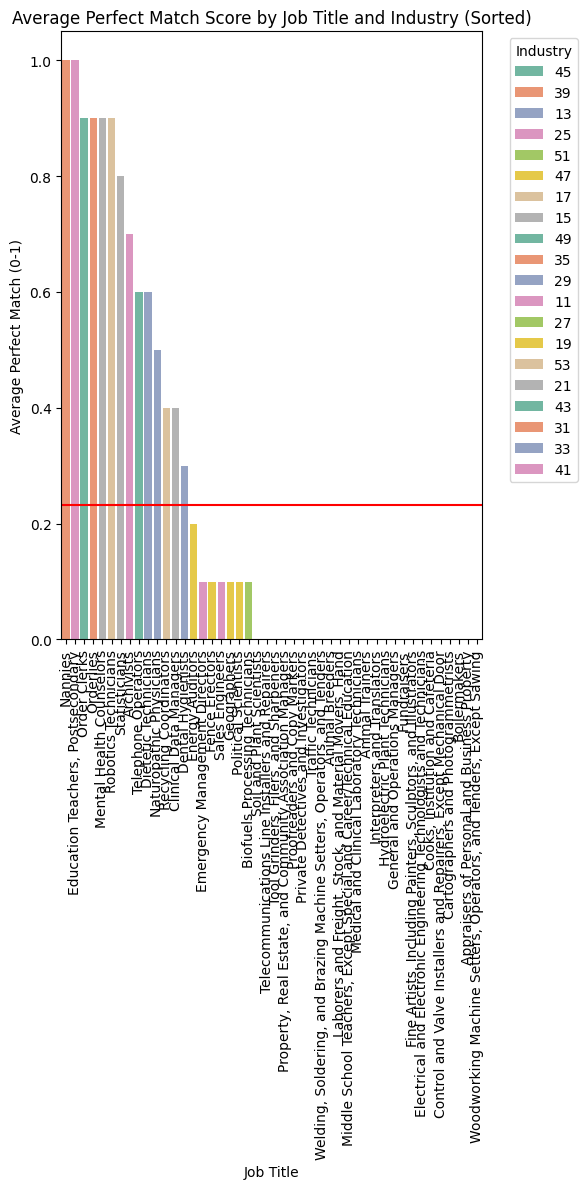

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming plot_data is your DataFrame (e.g., no_prompt_df)
plot_data["ind"] = plot_data["ind"].astype(str)
plot_data["zone"] = plot_data["zone"].astype(str)

# Calculate mean perfect_match per title to determine sort order
order = plot_data.groupby("title")["perfect_match"].mean().sort_values(ascending=False).index

# Create figure
plt.figure(figsize=(6, 12))

# Bar plot: mean perfect_match by title, colored by ind, sorted descending
sns.barplot(data=plot_data, x="title", y="perfect_match", hue="ind", palette="Set2", order=order)
#add a mean score
plt.axhline(y= plot_data["perfect_match"].sum() / len(plot_data), color='r', linestyle='-')

# Customize
plt.xticks(rotation=90)
plt.title('Average Perfect Match Score by Job Title and Industry (Sorted)')
plt.xlabel('Job Title')
plt.ylabel('Average Perfect Match (0-1)')
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show plot
plt.show()

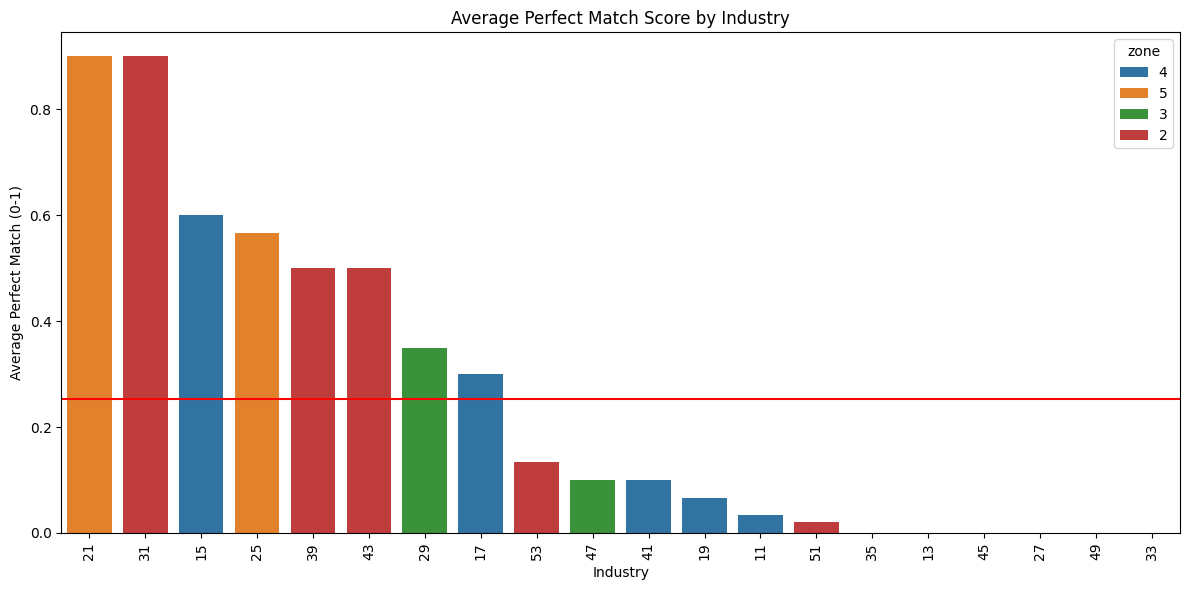

In [226]:
ind_plot = plot_data[["ind", "perfect_match", "related", "zone"]].groupby("ind").agg({"perfect_match":"mean", "related":"mean", "zone":"first"}).reset_index()

# plot perfect match by industry
plt.figure(figsize=(12, 6))
sns.barplot(data=ind_plot, x="ind", y="perfect_match", order=ind_plot.sort_values("perfect_match", ascending=False)["ind"], hue="zone")
#add a mean score line
plt.axhline(y= ind_plot["perfect_match"].mean(), color='r', linestyle='-')
plt.xticks(rotation=90)
plt.title('Average Perfect Match Score by Industry')
plt.xlabel('Industry')
plt.ylabel('Average Perfect Match (0-1)')
plt.tight_layout()
plt.show()


In [ ]:
zone_plot = plot_data[["zone", "perfect_match", "related"]].groupby("zone").agg({"perfect_match":"mean", "related":"mean"}).reset_index()


,zone,perfect_match,related
0,2,0.266667,0.700000
1,3,0.166667,0.566667
2,4,0.058333,1.483333
3,5,0.571429,2.085714


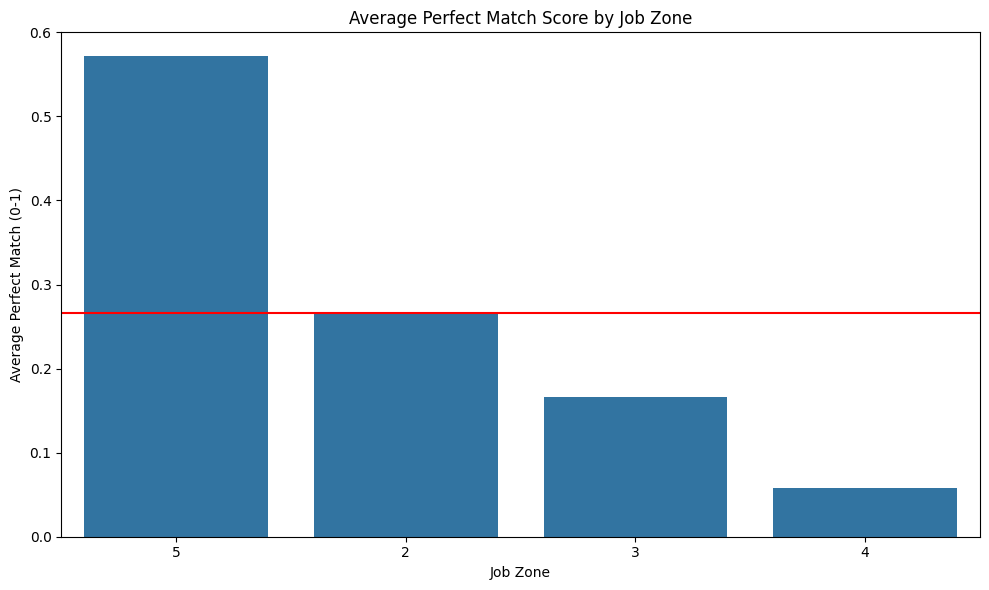

In [237]:
# plot perfect match by zone
plt.figure(figsize=(10, 6))
sns.barplot(data=zone_plot, x="zone", y="perfect_match", order=zone_plot.sort_values("perfect_match", ascending=False)["zone"])
#add a mean score line
plt.axhline(y= zone_plot["perfect_match"].mean(), color='r', linestyle='-')
plt.title('Average Perfect Match Score by Job Zone')
plt.xlabel('Job Zone')
plt.ylabel('Average Perfect Match (0-1)')
plt.tight_layout()
plt.show()


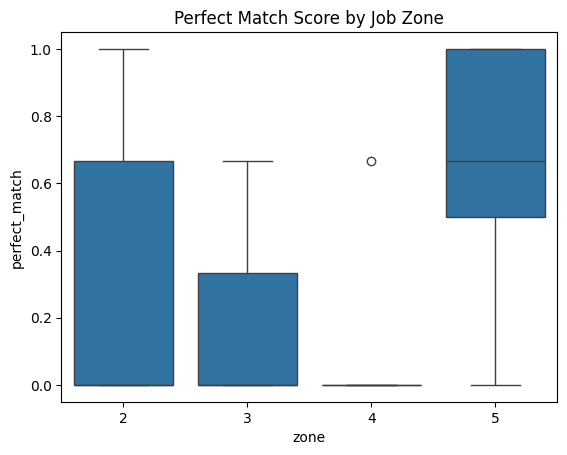

In [130]:
# plot the match score by job zone
sns.boxplot(x='zone', y='perfect_match', data=score_df)
plt.title('Perfect Match Score by Job Zone')
plt.show()

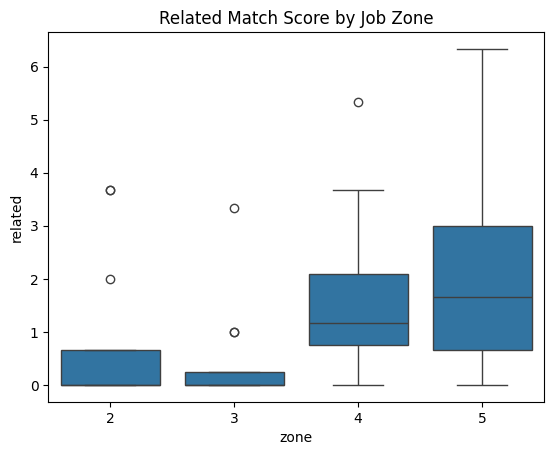

In [131]:
#plot the related score by job zone
sns.boxplot(x='zone', y='related', data=score_df)
plt.title('Related Match Score by Job Zone')
plt.show()

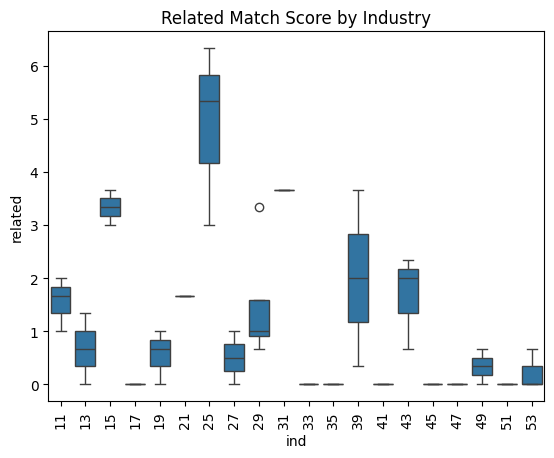

In [132]:
#plot the related score by industry
sns.boxplot(x='ind', y='related', data=score_df)
plt.title('Related Match Score by Industry')
plt.xticks(rotation=90)
plt.show()


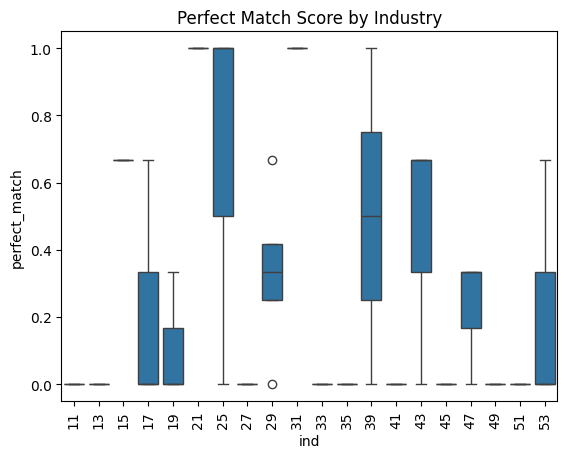

In [133]:
#plot the perfect match by industry
sns.boxplot(x='ind', y='perfect_match', data=score_df)
plt.title('Perfect Match Score by Industry')
plt.xticks(rotation=90)
plt.show()


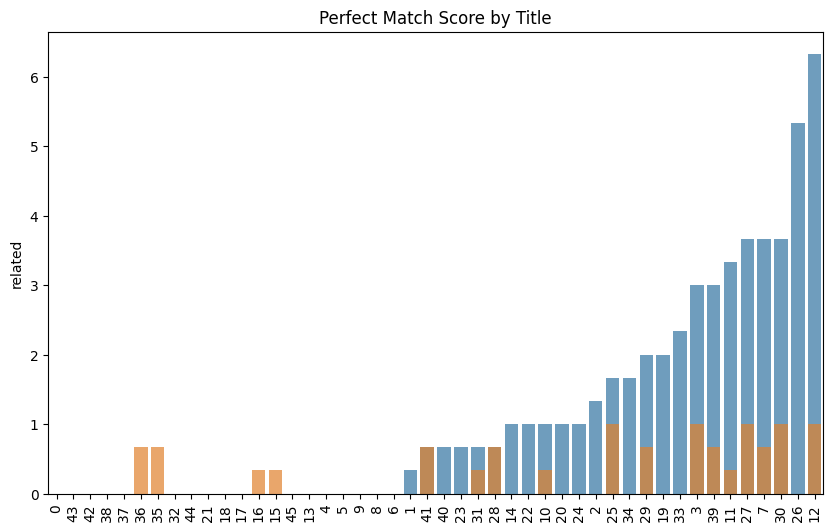

In [148]:
# plot for perfect match by title
plt.figure(figsize=(10, 6))
#x axis is the title, y axis is the score
# make the bars transparent
sns.barplot(score_df["related"], order=score_df["related"].sort_values().index, alpha=0.7)
sns.barplot(score_df["perfect_match"], alpha=0.7)
#plot the related score

#rotate the title
plt.xticks(rotation=90)
#add title
plt.title('Perfect Match Score by Title')
plt.show()


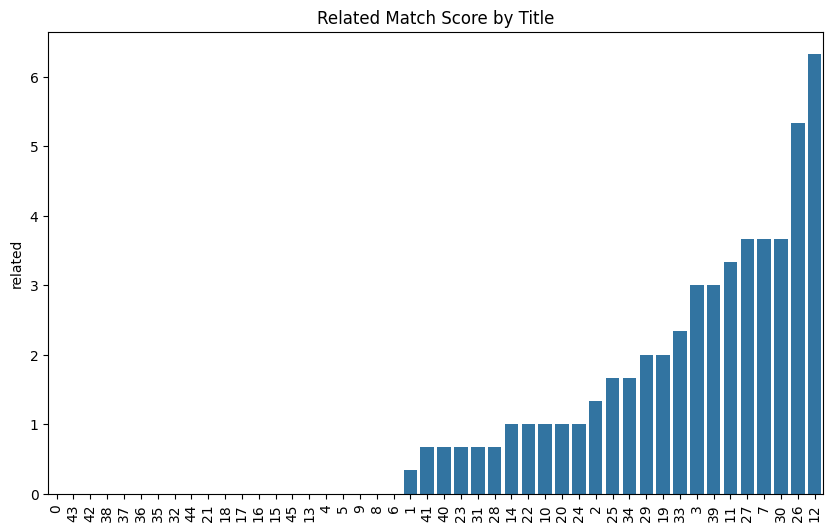

In [141]:
# plot for related match by title
plt.figure(figsize=(10, 6))
#x axis is the title, y axis is the score
sns.barplot(score_df["related"], order=score_df["related"].sort_values().index)
plt.xticks(rotation=90)
plt.title('Related Match Score by Title')
plt.show()

In [143]:
score_df_ind = score_df.groupby("ind").agg({
    "perfect_match": "mean",
    "related": "mean",
}).reset_index()
score_df_ind

,ind,perfect_match,related
0,11,0.000000,1.555556
1,13,0.000000,0.666667
2,15,0.666667,3.333333
3,17,0.222222,0.000000
4,19,0.111111,0.555556
5,21,1.000000,1.666667
6,25,0.666667,4.888889
7,27,0.000000,0.500000
8,29,0.333333,1.500000
9,31,1.000000,3.666667


In [127]:
df = pd.read_json("results/ajob_match_2503_1558/llama3.2_prompt1_results3.json", dtype={"rating": "object"}).dropna()
#in interation, change 0 to 8, 1 to 9, 2 to 10, 3 to 11
df["iteration"] = df["iteration"].apply(lambda x: x+8)
# # # drop the ones with iteration 11
# df = df[df["iteration"] != 11]
# # # #save df
df.to_json("results/ajob_match_2503_1545/llama3.2_prompt1_results3.json", orient='records')
df

,code,title,description,ind,rating,reason,iteration
47,11-9141.00,"Property, Real Estate, and Community Associati...","Plan, direct, or coordinate the selling, buyin...",11,3314131121413111133113221114113133413531113122...,[Not directly related to property management o...,8.0
48,11-1021.00,General and Operations Managers,"Plan, direct, or coordinate the operations of ...",11,2114133125542111225145225214124145454442131324...,[This task might be relevant to cabinet makers...,8.0
49,11-9161.00,Emergency Management Directors,Plan and direct disaster response or crisis ma...,11,1134331211331111113313131114113113412151133111...,[Building and maintaining emergency management...,8.0
50,13-2022.00,Appraisers of Personal and Business Property,Appraise and estimate the fair value of tangib...,13,1311231222332111121112351114113123423331131121...,[Lack of relevance to appraisal and valuation ...,8.0
51,13-1131.00,Fundraisers,Organize activities to raise funds or otherwis...,13,1313331213332111113132131333134323333332123333...,[This statement seems unrelated to the occupat...,8.0
...,...,...,...,...,...,...,...
183,51-4194.00,"Tool Grinders, Filers, and Sharpeners","Perform precision smoothing, sharpening, polis...",51,1113131111112113135122111111413133322311111111...,"[Not directly related to the occupation, as it...",10.0
184,53-6041.00,Traffic Technicians,Conduct field studies to determine traffic vol...,53,1111111112321111312111331212111111432241111111...,[Not relevant to traffic management or transpo...,10.0
185,53-1042.01,Recycling Coordinators,Supervise curbside and drop-off recycling prog...,53,2325111312413121135114324114134134433353111121...,[Not directly related to recycling or waste ma...,10.0
186,53-7062.00,"Laborers and Freight, Stock, and Material Move...","Manually move freight, stock, luggage, or othe...",53,3512111132321111112112135213232133542231112113...,"[Requires manual labor and physical effort, bu...",10.0


In [151]:
df = pd.read_json("results/job_match_0303_1550/llama3.2_prompt1_results3.json", dtype={"rating": "object"}).dropna()
#in interation, change 0 to 8, 1 to 9, 2 to 10, 3 to 11
# df["iteration"] = df["iteration"].apply(lambda x: x+1)
# # # drop the ones with iteration 11
# df = df[df["iteration"] != 11]
# # # #save df
# df.to_json("results/job_match_0303_1550/llama3.2_prompt1_results1.json", orient='records')
df

,code,title,description,ind,rating,reason,iteration
0,11-9141.00,"Property, Real Estate, and Community Associati...","Plan, direct, or coordinate the selling, buyin...",11,3314131121413111133113221114113133413531113122...,[Not directly related to property management o...,8
1,11-1021.00,General and Operations Managers,"Plan, direct, or coordinate the operations of ...",11,2114133125542111225145225214124145454442131324...,[This task might be relevant to cabinet makers...,8
2,11-9161.00,Emergency Management Directors,Plan and direct disaster response or crisis ma...,11,1134331211331111113313131114113113412151133111...,[Building and maintaining emergency management...,8
3,13-2022.00,Appraisers of Personal and Business Property,Appraise and estimate the fair value of tangib...,13,1311231222332111121112351114113123423331131121...,[Lack of relevance to appraisal and valuation ...,8
4,13-1131.00,Fundraisers,Organize activities to raise funds or otherwis...,13,1313331213332111113132131333134323333332123333...,[This statement seems unrelated to the occupat...,8
...,...,...,...,...,...,...,...
136,51-4194.00,"Tool Grinders, Filers, and Sharpeners","Perform precision smoothing, sharpening, polis...",51,1113131111112113135122111111413133322311111111...,"[Not directly related to the occupation, as it...",10
137,53-6041.00,Traffic Technicians,Conduct field studies to determine traffic vol...,53,1111111112321111312111331212111111432241111111...,[Not relevant to traffic management or transpo...,10
138,53-1042.01,Recycling Coordinators,Supervise curbside and drop-off recycling prog...,53,2325111312413121135114324114134134433353111121...,[Not directly related to recycling or waste ma...,10
139,53-7062.00,"Laborers and Freight, Stock, and Material Move...","Manually move freight, stock, luggage, or othe...",53,3512111132321111112112135213232133542231112113...,"[Requires manual labor and physical effort, bu...",10
